### 1.Imports

In [1]:
import os
import matplotlib.pyplot as plt
import time, os, json
import pandas as pd
from scipy import stats 
from tqdm import tqdm
import seaborn as sns
import jax

from jax import random
from jax.config import config 
import jax.numpy as np
from jax import vmap
import pdb
import optax
from functools import partial

import math
import csv
import time
#from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import numpy
from util import create_gratings, create_data
from SSN_classes_jax_jit import SSN2DTopoV1_AMPAGABA_ONOFF
from training import train_SSN_vmap
from analysis import plot_results, plot_losses, response_matrix, findRmax, initial_acc

### 2. Parameters

2.1 Network parameters

In [16]:
#Gabor parameters 
sigma_g= 0.5
k = np.pi/(6*sigma_g)

#Stimuli parameters
ref_ori = 55
offset = 4

#Assemble parameters in dictionary
general_pars = dict(k=k , edge_deg=3.2,  degree_per_pixel=0.05)
stimuli_pars = dict(outer_radius=3, inner_radius=2.5, grating_contrast=0.8, std = 0, jitter_val = 5)
stimuli_pars.update(general_pars)

#Network parameters
class ssn_pars():
    n = 2
    k = 0.04
    tauE = 30 # in ms
    tauI = 10 # in ms~
    psi = 0.774
    A=None
    tau_s = np.array([5, 7, 100]) #in ms, AMPA, GABA, NMDA current decay time constants
    

#Grid parameters
class grid_pars():
    gridsize_Nx = 9 # grid-points across each edge # gives rise to dx = 0.8 mm
    gridsize_deg = 2 * 1.6 # edge length in degrees
    magnif_factor = 2  # mm/deg
    hyper_col = 0.8 # mm   
    sigma_RF = 0.4 # deg (visual angle)

class conn_pars():
    PERIODIC = False
    p_local = [0.4, 0.7]
    
class filter_pars():
    sigma_g = numpy.array(0.5)
    conv_factor = numpy.array(2)
    k = numpy.array(1.0471975511965976)
    edge_deg = numpy.array( 3.2)
    degree_per_pixel = numpy.array(0.05)
    
class conv_pars:
    dt = 1
    xtol = 1e-05
    Tmax = 1000
    verbose = False
    silent = True
    Rmax_E = None
    Rmax_I= None

class loss_pars:
    lambda_1 = 1
    lambda_2 = 1
    lambda_w = 1
    lambda_b = 1



2.2 Optimization parameters

In [17]:
# Caleb's params for the full (with local) model:
Js0 = [1.82650658, 0.68194475, 2.06815311, 0.5106321]
gE, gI = 0.37328625, 0.26144141

sigEE, sigIE = 0.2, 0.40
sigEI, sigII = .09, .09

make_J2x2 = lambda Jee, Jei, Jie, Jii: np.array([[Jee, -Jei], [Jie,  -Jii]]) * np.pi * ssn_pars.psi
J_2x2 = make_J2x2(*Js0)
s_2x2 = np.array([[sigEE, sigEI],[sigIE, sigII]])


signs=np.array([[1, -1], [1, -1]])
logJ_2x2 =np.log(J_2x2*signs)
logs_2x2 = np.log(s_2x2)


#Excitatory and inhibitory constants for extra synaptic GABA
c_E = 5.0
c_I = 5.0

#Sigmoid parameters
N_neurons = 25

w_sig = numpy.random.normal(size=(N_neurons,)) / np.sqrt(N_neurons)

b_sig = 0.0

sigma_oris = np.asarray([1000.0]) #np.asarray([45.0, 45.0])

#Optimization pars
opt_pars = dict(logJ_2x2 = logJ_2x2, logs_2x2 = logs_2x2, w_sig = w_sig, b_sig=b_sig, c_E = c_E, c_I = c_I, sigma_oris =sigma_oris)

#Initialise network to obtain constant A
ssn=SSN2DTopoV1_AMPAGABA_ONOFF(ssn_pars=ssn_pars, grid_pars=grid_pars, conn_pars=conn_pars, filter_pars=filter_pars, J_2x2=J_2x2, s_2x2=s_2x2, gE = gE, gI=gI, sigma_oris = sigma_oris)
ssn_pars.A=ssn.A

opt_pars['w_sig'] = np.asarray([ 0.12715884,  0.1882399 ,  0.07349919, -0.03255837,
               -0.17126298,  0.32166725, -0.01298537, -0.01052833,
               -0.03701853,  0.08791865, -0.09970778,  0.11917701,
                0.227474  ,  0.41530475, -0.1097217 , -0.19488868,
               -0.04270361,  0.09282126, -0.03740848, -0.11572354,
                0.40694624, -0.67116004, -0.05228559,  0.23142576,
                0.25945553])


In [18]:
#Set Rmax to maxium pre training values
Rmax_E, Rmax_I = findRmax(opt_pars, ssn_pars, grid_pars, conn_pars, gE, gI, filter_pars, conv_pars, stimuli_pars, ref_ori = ref_ori, offset = offset, inhibition=True)
conv_pars.Rmax_E = Rmax_E
conv_pars.Rmax_I = Rmax_I 

In [19]:
conv_pars.Rmax_I

DeviceArray(93.1122, dtype=float32)

2.3 Training parameters

In [20]:
#Number of epochs
epochs = 100
num_epochs_to_save =21
epochs_to_save = np.linspace(1 ,epochs, num_epochs_to_save).astype(int)
epochs_to_save = np.insert(epochs_to_save, 0, 0)
noise_type = 'additive'

eta=10e-4/10
sig_noise = 5
batch_size = 50

### 3. Saving results

In [21]:
#Name of results csv
home_dir = os.getcwd()

#Create folder for results
results_dir = os.path.join(home_dir, 'results', 'jitted_function', 'TESTING_PIPELINE') ###SPECIFY FOLDER 
if os.path.exists(results_dir) == False:
        os.makedirs(results_dir)
        
        
results_name = 'PIPELINE_TEST_2.csv' ##### SPECIFY NAME FOR RESULTS
if results_name == None:
    results_name = 'results.csv'

results_filename = os.path.join(results_dir, results_name)

## TRAINING

In [22]:
new_pars, val_loss_per_epoch, training_losses = train_SSN_vmap(opt_pars, ssn_pars, grid_pars, conn_pars, gE, gI, stimuli_pars, filter_pars,  conv_pars, loss_pars, epochs_to_save = epochs_to_save, results_filename=results_filename, ref_ori = ref_ori, offset = offset, batch_size = batch_size, epochs = epochs, sig_noise =sig_noise, eta=eta, noise_type = noise_type )

Training model with learning rate 0.0001, sig_noise 5 at offset 4, lam_w 1, batch size 50
Before training  -- loss: 5.439000129699707, true accuracy: 0.48000001907348633 , Bernoulli accuracy: 0.48000001907348633 (learning rate: 0.0001)
Saving results to csv  /mnt/d/ABG_Projects_Backup/ssn_modelling/ssn-simulator/results/jitted_function/TESTING_PIPELINE/PIPELINE_TEST_2.csv
Training loss: 279.446533203125 ¦ Validation -- loss: 5.573721885681152, true accuracy: 0.7300000190734863, Bernoulli accuracy: 0.7200000286102295 at epoch 1, (time 4.8653833866119385, 1.1721394062042236)
Training loss: 291.2247619628906 ¦ Validation -- loss: 5.610429763793945, true accuracy: 0.44999998807907104, Bernoulli accuracy: 0.5400000214576721 at epoch 5, (time 4.611705780029297, 1.1350135803222656)
Training loss: 354.9936218261719 ¦ Validation -- loss: 5.57484245300293, true accuracy: 0.6100000143051147, Bernoulli accuracy: 0.4300000071525574 at epoch 10, (time 4.682247877120972, 1.1396074295043945)
Training 

In [16]:
loss_pars.lambda_2

1

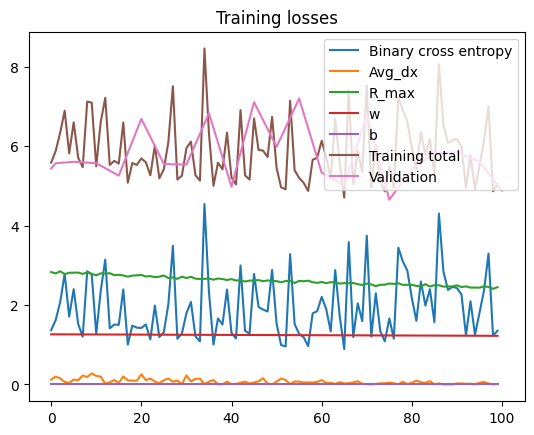

In [23]:
plot_losses(training_losses, val_loss_per_epoch, epochs_to_save)

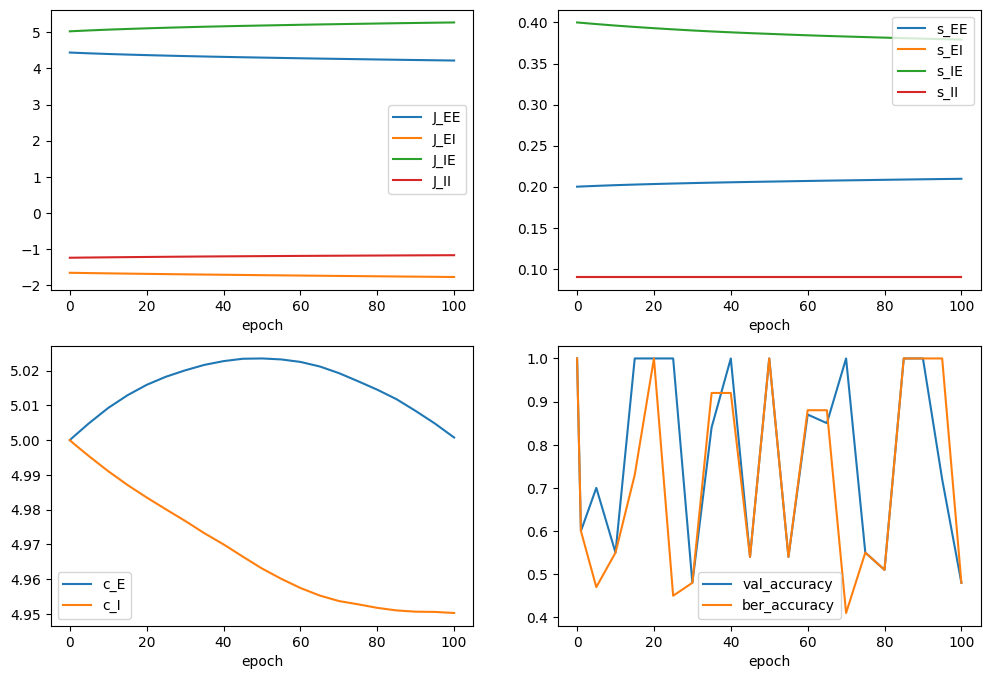

In [17]:
plot_results(results_filename)

## RESULTS ANALYSIS 

In [17]:
radius_list = np.linspace(0,3, 10)
ori_list = np.linspace(0, 360, 13)

In [19]:
#Responses at range of orientations and radius - output size (number of radii x number of neurons x number of orientations)
pre_response_matrix = response_matrix(opt_pars, ssn_pars, grid_pars, conn_pars, conv_pars, gE, gI, filter_pars, stimuli_pars, radius_list, ori_list)
#save_matrix = os.path.join(results_dir, 'pre_response_matrix')
#np.save(save_matrix, pre_response_matrix)

0.0
Mean population response 1.0385562181472778 (max in population 1.2249644994735718), centre neuron 0.9887478947639465
Mean population response 1.8467905521392822 (max in population 10.5079927444458), centre neuron 10.5079927444458
Mean population response 3.2313320636749268 (max in population 19.99537467956543), centre neuron 19.99537467956543
Mean population response 3.451544761657715 (max in population 19.676740646362305), centre neuron 19.676740646362305
Mean population response 3.521306276321411 (max in population 17.547273635864258), centre neuron 17.547273635864258
Mean population response 3.192422389984131 (max in population 20.940332412719727), centre neuron 16.308012008666992
Mean population response 3.320651054382324 (max in population 21.30348777770996), centre neuron 15.427820205688477
Mean population response 3.0609657764434814 (max in population 20.694643020629883), centre neuron 13.623327255249023
Mean population response 3.615548610687256 (max in population 22.530523

Mean population response 1.603607416152954 (max in population 7.543431282043457), centre neuron 7.543431282043457
Mean population response 1.5547659397125244 (max in population 6.344517707824707), centre neuron 0.4898203909397125
Mean population response 1.4996609687805176 (max in population 11.887389183044434), centre neuron 0.06767542660236359
Mean population response 1.683906078338623 (max in population 15.145536422729492), centre neuron 0.6338692903518677
Mean population response 1.25913667678833 (max in population 10.156283378601074), centre neuron 0.7256597280502319
Mean population response 1.2806785106658936 (max in population 10.401130676269531), centre neuron 0.5508095026016235
Mean population response 1.255218505859375 (max in population 10.023730278015137), centre neuron 0.5622805953025818
Mean population response 1.2552261352539062 (max in population 10.173937797546387), centre neuron 0.535711407661438
Mean population response 1.2030407190322876 (max in population 9.5778064

In [20]:
new_pars['logJ_2x2'] = np.log(new_pars['logJ_2x2']*signs)
new_pars['logs_2x2'] = np.log(new_pars['logs_2x2'])
post_response_matrix = response_matrix(new_pars, ssn_pars, grid_pars, conn_pars, conv_pars, gE, gI, filter_pars, stimuli_pars, radius_list, ori_list)
#save_matrix = os.path.join(results_dir, 'post_response_matrix')
#np.save(save_matrix, post_response_matrix)

0.0
Mean population response 0.9513529539108276 (max in population 1.0997830629348755), centre neuron 0.924632728099823
Mean population response 1.690843939781189 (max in population 9.5123872756958), centre neuron 9.5123872756958
Mean population response 2.872462749481201 (max in population 17.379480361938477), centre neuron 17.379480361938477
Mean population response 3.4422192573547363 (max in population 19.96957778930664), centre neuron 19.96957778930664
Mean population response 2.8387866020202637 (max in population 14.67203140258789), centre neuron 11.540739059448242
Mean population response 3.4998576641082764 (max in population 20.2330379486084), centre neuron 20.2330379486084
Mean population response 2.45369029045105 (max in population 17.186119079589844), centre neuron 10.342998504638672
Mean population response 2.860333204269409 (max in population 19.25491714477539), centre neuron 12.708206176757812
Mean population response 2.6574578285217285 (max in population 18.35087776184082

Mean population response 1.484938144683838 (max in population 6.887463569641113), centre neuron 6.887463569641113
Mean population response 1.4507932662963867 (max in population 4.725286483764648), centre neuron 2.370154619216919
Mean population response 1.412853479385376 (max in population 10.896523475646973), centre neuron 0.06640049070119858
Mean population response 1.310998797416687 (max in population 10.015776634216309), centre neuron 0.7062772512435913
Mean population response 1.1971840858459473 (max in population 9.272153854370117), centre neuron 0.769259512424469
Mean population response 1.1869375705718994 (max in population 9.306031227111816), centre neuron 0.6203436851501465
Mean population response 1.2041547298431396 (max in population 9.018241882324219), centre neuron 0.6272227168083191
Mean population response 1.3077735900878906 (max in population 11.509440422058105), centre neuron 0.5044389963150024
Mean population response 1.1532926559448242 (max in population 9.043687820

In [94]:
array = ssn.ori_map[2:7, 2:7]
array=array.ravel()

In [103]:
test_oris = np.linspace(40, 170, 8)
indices = []
for test_ori in test_oris:
    idx = (np.abs(array - test_ori)).argmin()
    indices.append(idx)

testing_angles = [array[idx] for idx in indices]
testing_angles

[DeviceArray(37.070847, dtype=float32),
 DeviceArray(59.624653, dtype=float32),
 DeviceArray(79.09537, dtype=float32),
 DeviceArray(97.5979, dtype=float32),
 DeviceArray(113.25367, dtype=float32),
 DeviceArray(129.67758, dtype=float32),
 DeviceArray(153.29688, dtype=float32),
 DeviceArray(170.18488, dtype=float32)]

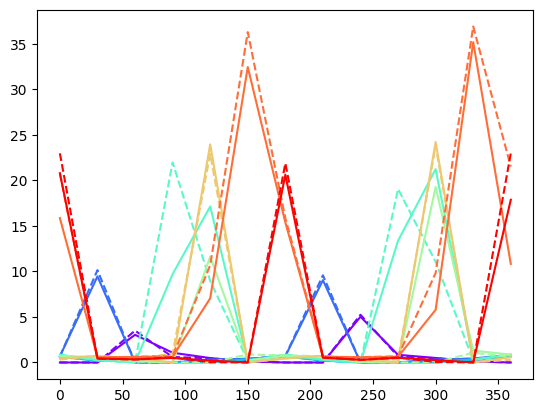

In [106]:
plot_tuning_curves(pre_response_matrix, indices, radius_idx, post_response_matrix)

(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)


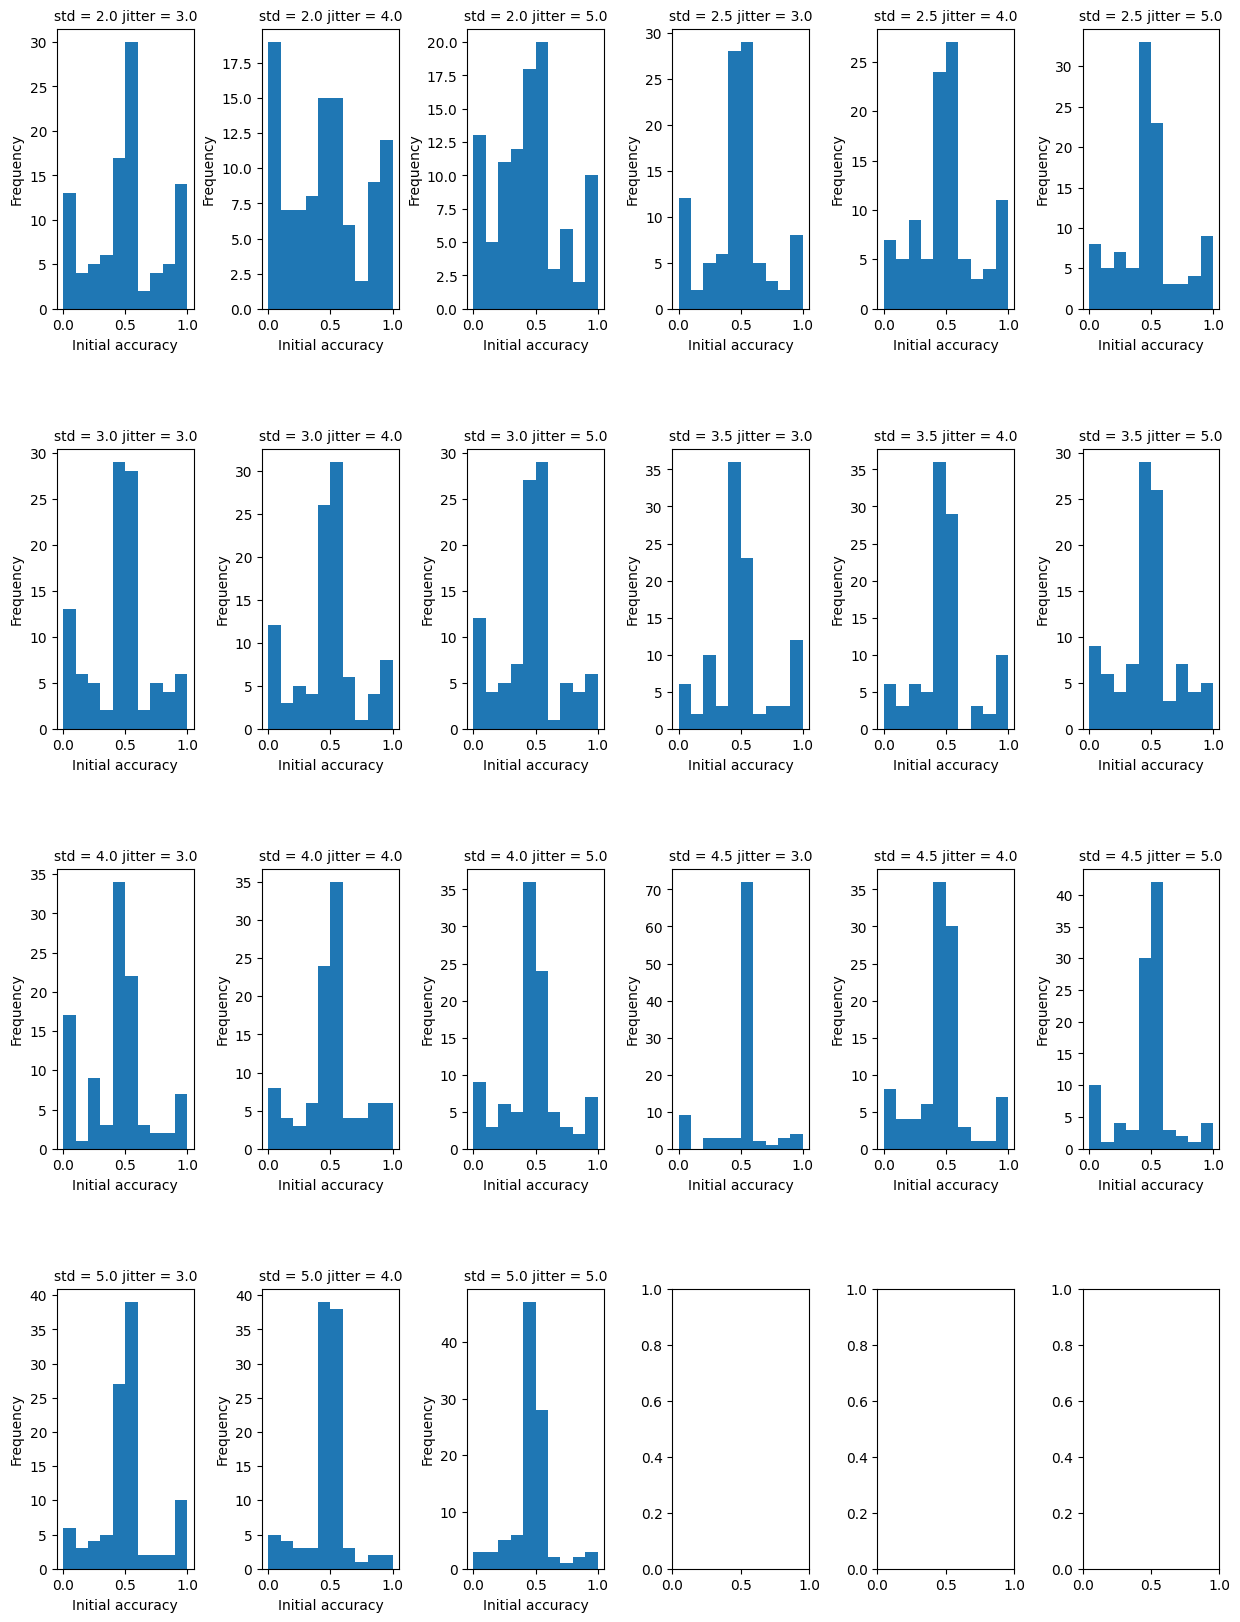

In [9]:
#from analysis

all_accuracies, low_acc, percent_50, good_w_s = initial_acc( opt_pars, ssn_pars, grid_pars, conn_pars, gE, gI, filter_pars,  conv_pars, stimuli_pars,  loss_pars, min_sig_noise = 2, len_noise = 7, max_sig_noise =5 , max_jitter = 5, p = 0.9)

(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)


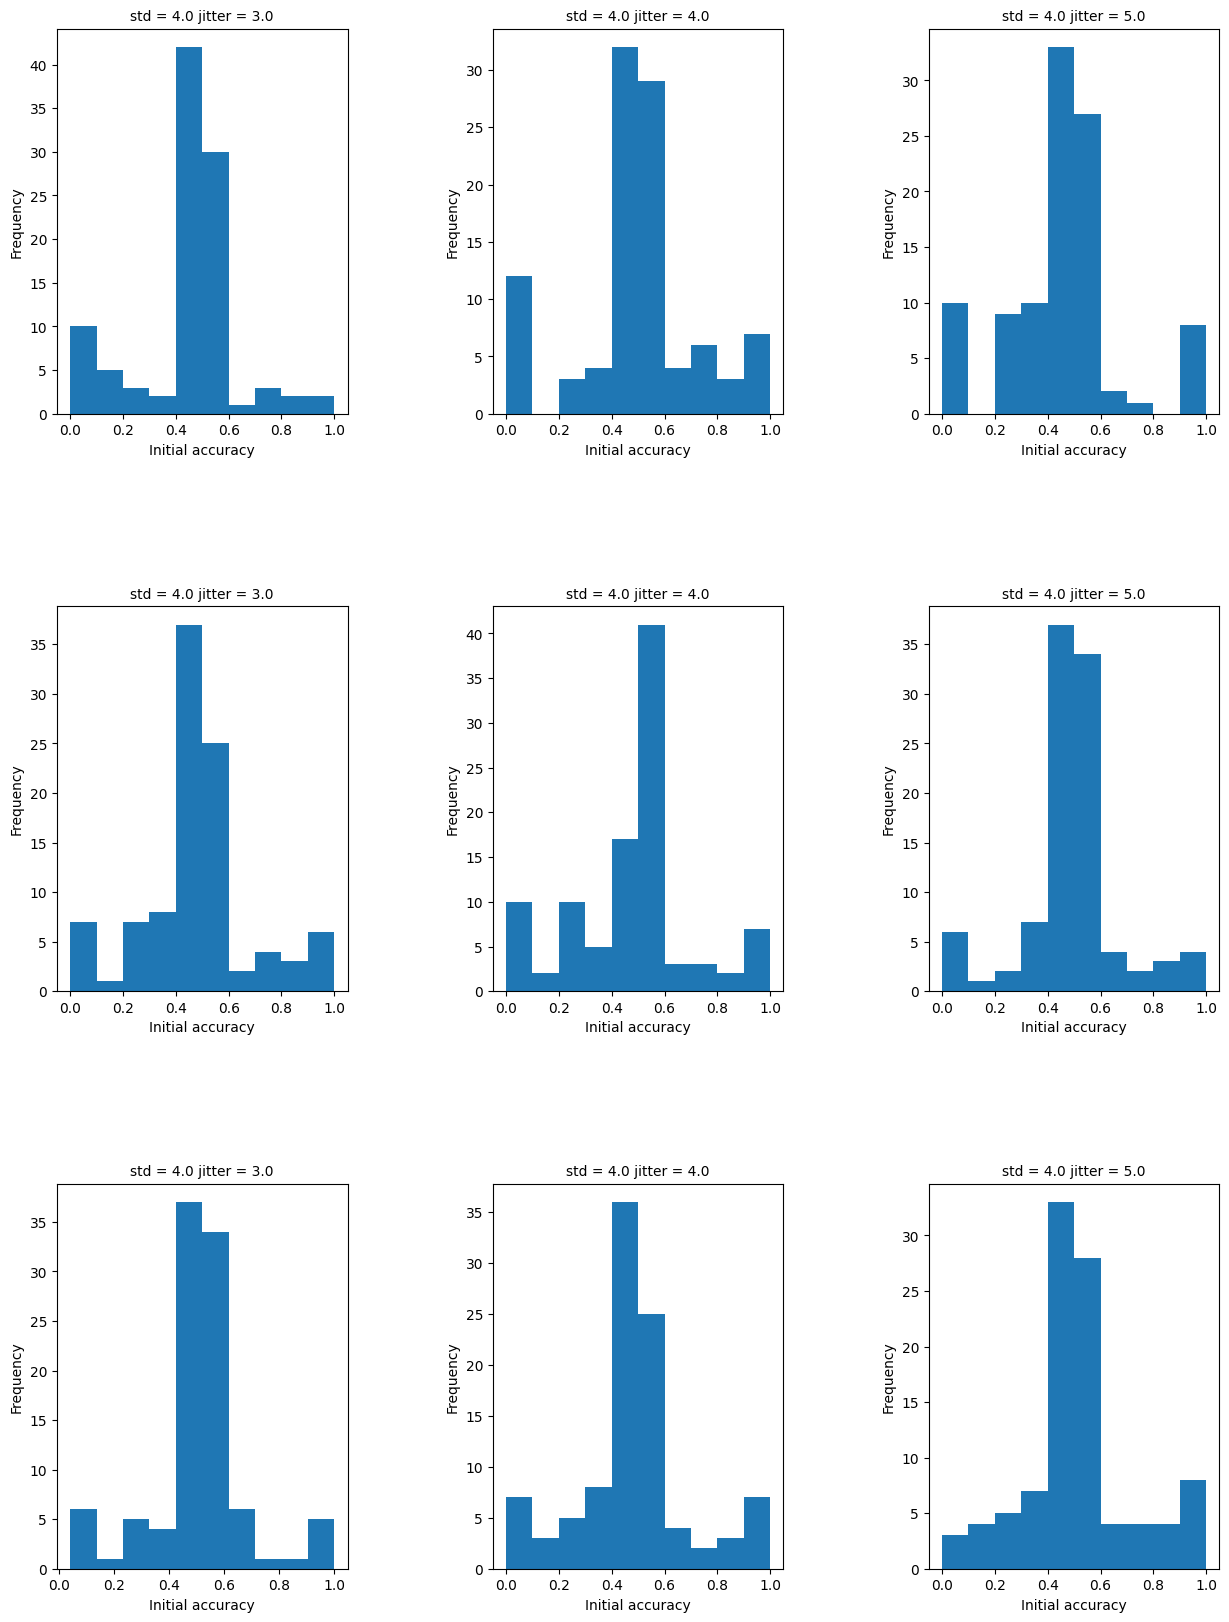

In [10]:
all_accuracies, low_acc, percent_50, good_w_s = initial_acc( opt_pars, ssn_pars, grid_pars, conn_pars, gE, gI, filter_pars,  conv_pars, stimuli_pars,  loss_pars, min_sig_noise = 4, len_noise = 3, max_sig_noise =4 , max_jitter = 5, p = 0.9)

In [11]:
good_w_s

[[],
 [],
 [],
 [],
 [],
 [DeviceArray([ 0.12715884,  0.1882399 ,  0.07349919, -0.03255837,
               -0.17126298,  0.32166725, -0.01298537, -0.01052833,
               -0.03701853,  0.08791865, -0.09970778,  0.11917701,
                0.227474  ,  0.41530475, -0.1097217 , -0.19488868,
               -0.04270361,  0.09282126, -0.03740848, -0.11572354,
                0.40694624, -0.67116004, -0.05228559,  0.23142576,
                0.25945553], dtype=float32)],
 [DeviceArray([ 0.2884025 , -0.36562824, -0.08718013, -0.16805708,
               -0.24917226,  0.10727952, -0.02719139,  0.13420987,
               -0.05520045,  0.00442323, -0.15827724, -0.1112233 ,
               -0.08722857,  0.12320393,  0.1673552 , -0.2359933 ,
               -0.0438695 ,  0.31437063,  0.3452079 ,  0.12244476,
               -0.2244972 ,  0.1830301 ,  0.21609142,  0.2178404 ,
                0.26187456], dtype=float32)],
 [],
 []]